# Response time (RT) of participants in a flanker experiment

In this experiment, we're diving into the fascinating world of flankers, where participants had to hit the left or right arrow keys to show the direction of a center arrow. But wait, there's a twist! Sneaky flanking arrows mess with their minds—some pointing the same way as the center arrow (congruent), while others go rogue (incongruent)!


To achieve the project goals, the researchers need to obtain RT estimates for each condition from a representative sample of 27 human participants. Each participant completed 40 trials in each condition, with a total of approximately 160 trials per participant. The data has a nesting structure with trials (n=160) nested within conditions (n=3) nested within participants (n=27).

We're gonna find out if incongruent flanking leads to slower reaction times due to visual confusion and cognitive 
interference!

In [2]:
# IMPORT & READ
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('flanker_rt_data.csv')

target = "rt"

In [3]:
df.sample(5)

,participant,block,trial,flankers,rt
3252,s27,3,14,incongruent,0.474262
3009,s6,5,25,neutral,0.452540
3761,s17,4,15,neutral,0.574008
2550,s4,1,13,neutral,0.557795
3692,s17,2,10,congruent,0.458207


# FUNCTIONS

In [59]:
# MUTUAL_INFORMATION

from sklearn.feature_selection import mutual_info_regression
def m_info_r(X, y):
   
    X_encoded = X.select_dtypes(include="object").apply(lambda x: x.factorize()[0])  # Label encoding for categorical
    
    X_combined = pd.concat([X_encoded, X.select_dtypes(exclude="object")], axis=1) # Combined categorical & numerical col
    
    mi_scores = mutual_info_regression(X_combined, y, discrete_features="auto", random_state=0) # Calculate mi scores
    
    # Create a Series with feature names as index and sorted mutual information scores
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_combined.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

from sklearn.feature_selection import mutual_info_classif
def m_info_c(X, y):
    
    X_encoded = X.select_dtypes(include="object").apply(lambda x: x.factorize()[0]) # Label encoding for categoricals
    
    X_combined = pd.concat([X_encoded, X.select_dtypes(exclude="object")], axis=1) # Combine categorical & numerical columns
    
    # Calculate mutual information scores using mutual_info_classification
    mi_scores = mutual_info_classif(X_combined, y, discrete_features="auto", random_state=0)
    
    # Create a Series with feature names as index and sorted mutual information scores
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_combined.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores
 
def plot_mi_scores(mi_scores, top_n=20):
    plt.figure(dpi=100, figsize=(10, 6))
    sns.barplot(x=mi_scores.head(top_n), y=mi_scores.head(top_n).index, palette='viridis')
    plt.title("Mutual Information Scores")
    plt.show()

In [7]:
# SEABORN_VISUALIZATION

def visualize_numerical_columns(df, num_cols_per_row=3):
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    # Calculate the number of rows needed for subplots
    num_rows = (len(numerical_cols) - 1) // num_cols_per_row + 1

    # Set plot style and palette
    sns.set_style("dark")
    sns.set_palette("dark")

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(12, 4 * num_rows))
    fig.tight_layout(pad=4.0)

    # Plot histograms for numerical columns
    for ax, col in zip(axes.flatten(), numerical_cols):
        sns.histplot(df[col], ax=ax, edgecolor='white', color='#a2d2ff', bins=20)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')

    # Remove empty subplots
    if len(numerical_cols) % num_cols_per_row != 0:
        empty_subplots = num_rows * num_cols_per_row - len(numerical_cols)
        for ax in axes.flatten()[-empty_subplots:]:
            ax.remove()

    plt.show()

def seaborn_correlation_matrix(df):
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = df.corr(numeric_only=True)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 4))

    # Generate a custom colormap
    cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, annot_kws={"fontsize": 8})

    # Show the plot
    plt.show()

def visualize_binary_relationships(df, target_column):
    g = sns.pairplot(data=df, hue=target_column, palette='seismic', height=1.2, diag_kind='kde', diag_kws=dict(fill=True), plot_kws=dict(s=10))
    g.set(xticklabels=[])




In [52]:
# PLOTLY_VISUALIZATION

import plotly.graph_objects as go
import plotly.express as px


def explore_dependent_variable(target):
    # Fit a normal distribution to the target data
    mu, sigma = stats.norm.fit(target)

    # Create a histogram of the target column
    hist_data = go.Histogram(x=target, nbinsx=50, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='blueviolet'))

    # Calculate the normal distribution based on the fitted parameters
    x_norm = np.linspace(target.min(), target.max(), 100)
    y_norm = stats.norm.pdf(x_norm, mu, sigma)

    # Create the normal distribution overlay
    norm_data = go.Scatter(x=x_norm, y=y_norm, mode="lines", name=f"Normal dist. (μ={mu:.2f}, σ={sigma:.2f})", line=dict(color="green"))

    # Combine the histogram and the overlay
    fig = go.Figure(data=[hist_data, norm_data])

    # Set the layout for the plot
    fig.update_layout(
        title="Dependent Variable Distribution",
        xaxis_title="Dependent Variable",
        yaxis_title="Density",
        legend_title_text="Fitted Normal Distribution",
        plot_bgcolor='rgba(32, 32, 32, 1)',
        paper_bgcolor='rgba(32, 32, 32, 1)',
        font=dict(color='white')
    )

    # Create a Q-Q plot
    qq_data = stats.probplot(target, dist="norm")
    qq_fig = px.scatter(x=qq_data[0][0], y=qq_data[0][1], labels={'x': 'Theoretical Quantiles', 'y': 'Ordered Values'}, color_discrete_sequence=["blueviolet"])
    qq_fig.update_layout(
        title="Q-Q plot",
        plot_bgcolor='rgba(32, 32, 32, 1)',
        paper_bgcolor='rgba(32, 32, 32, 1)',
        font=dict(color='white')
    )

    # Calculate the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(qq_data[0][0], qq_data[0][1])
    line_x = np.array(qq_data[0][0])
    line_y = intercept + slope * line_x

    # Add the line of best fit to the Q-Q plot
    line_data = go.Scatter(x=line_x, y=line_y, mode="lines", name="Normal Line", line=dict(color="yellow"))

    # Update the Q-Q plot with the normal line
    qq_fig.add_trace(line_data)

    # Show the plots
    fig.show()
    qq_fig.show()


def explore_categorical_relationships(df, group_column, target_column):
    grouped_counts = df[group_column].value_counts()
    grouped_averages = df.groupby(group_column)[target_column].mean()

    formatted_averages = ['' + f'{value:,.2f}' for value in grouped_averages.values]

    fig1 = go.Figure(data=[go.Bar(
        x=grouped_counts.index,
        y=grouped_counts.values,
        marker_color='rgb(76, 175, 80)',
        text=grouped_counts.values,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig1.update_layout(
        title=f'Distribution of {group_column}',
        xaxis_title=group_column,
        yaxis_title='Count',
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig2 = go.Figure(data=[go.Bar(
        x=grouped_averages.index,
        y=grouped_averages.values,
        marker_color='rgb(156, 39, 176)',
        text=formatted_averages,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig2.update_layout(
        title=f'Average {target_column} by {group_column}',
        xaxis_title=group_column,
        yaxis_title=target_column,
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig1.show()
    fig2.show()


def explore_numerical_correlation(df, feature_column, target_column):
    # Calculate correlation between feature and target
    feature_target_corr = df[feature_column].corr(df[target_column])
    print(f'Correlation between {feature_column} and {target_column}: {feature_target_corr}')

    # Create a scatter plot to visualize the relationship between feature and target
    fig = px.scatter(df, x=feature_column, y=target_column, title=f'{feature_column} vs {target_column}', color=feature_column, color_continuous_scale=px.colors.sequential.Purp)
    fig.update_layout(plot_bgcolor='rgb(30,30,30)', paper_bgcolor='rgb(30,30,30)', font=dict(color='white'))
    fig.show()



In [62]:
# EXTRACT_OUTLIERS

def extract_outliers(dataframe):
    outliers_data = []
    for column in dataframe.columns:
        if dataframe[column].dtype != 'object':  # Skip columns with non-numeric data types
            array = dataframe[column]
            # Get quartiles and IQR
            q1, q3 = np.percentile(array, [25, 75])
            iqr = q3 - q1

            # Calculate upper and lower bounds
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)

            outliers = array[(array <= lower_bound) | (array >= upper_bound)]
            total_outliers = len(outliers)
            outliers_data.append({'Column': column, 'Total Outliers': total_outliers})

    outliers_df = pd.DataFrame(outliers_data)
    return outliers_df

def plot_outliers(data, plot_type='violin', figsize=(10, 6)):
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # Choose plot type
    if plot_type == 'violin':
        sns.violinplot(data=data, ax=ax, inner="quartile", palette="pastel")
    elif plot_type == 'box':
        sns.boxplot(data=data, ax=ax)
    else:
        raise ValueError('Invalid plot type. Choose "violin" or "box".')

    # Set labels and title
    ax.set(xlabel='Columns', ylabel='Values', title='Outliers in Columns')

    # Rotate x-axis labels if needed
    ax.tick_params(axis='x') 

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a grid for better readability
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')

    # Adjust the aspect ratio of the subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    # Show the plot
    plt.show()

In [63]:
# REMOVE_OUTLIERS


#(Skewed Distribution)
def remove_outliers_IQR(df, column=None, k=3):
    if column is None:
        numeric_columns = df.select_dtypes(include=np.number).columns
    else:
        numeric_columns = [column]

    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    outliers = df[(df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)].any(axis=1)
    df_out = df[~outliers]

    return df_out

    # Example: remove_outliers_IQR(df, column=None, k=1.5)


#(Normal Distribution)
def remove_outliers_z_scores(df, column, z_score_lower=None, z_score_upper=None, z_score_threshold=None):
    if z_score_lower is not None and z_score_upper is not None:
        z_scores = scipy.stats.zscore(df[column])
        outliers = (z_scores < z_score_lower) | (z_scores > z_score_upper)
    elif z_score_threshold is not None:
        z_scores = scipy.stats.zscore(df[column])
        outliers = np.abs(z_scores) > z_score_threshold
    else:
        raise ValueError("Please specify either z_score_lower and z_score_upper or z_score_threshold.")
    
    return df[~outliers]

    # Example: remove_outliers_z_scores(df, 'column', z_score_lower=-1.96, z_score_upper=1.96)



# DATA EXPLORATION


In [3]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(df.shape)

# Check for any duplicate entries in the data.
print('')
print("Duplicate Values:")
print('(',df.duplicated().sum(),')')


# Display the data types of the columns
print("\nData Types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_columns = df.columns[df.isnull().any()]
if missing_columns.size > 0:
    missing_values = df[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(4289, 5)

Duplicate Values:
( 0 )

Data Types:
object     2
int64      2
float64    1
dtype: int64

No Missing Values Found


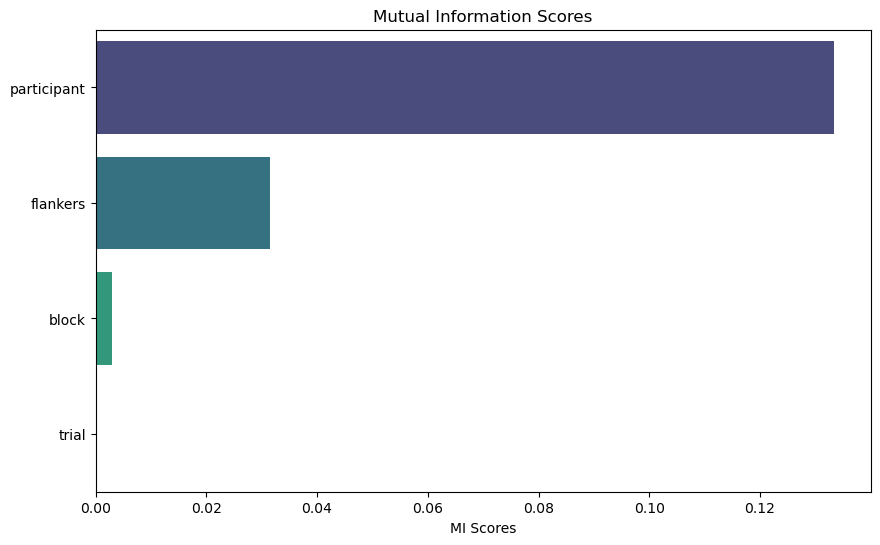

participant    0.133301
flankers       0.031506
block          0.003025
trial          0.000338
Name: MI Scores, dtype: float64


In [26]:
# MUTUAL INFORMATION SCORES

# Create a new DataFrame without null values
df_m = df.copy(deep=True)

# Calculate mutual information scores
X_m = df_m
y_m = X_m.pop(target)

# Calculate mutual information (_r or _c)
m_info_scores = m_info_r(X_m, y_m)

# Plot the mutual information scores
plot_mi_scores(m_info_scores, top_n=20)

# Display the top 10 mutual information scores
print(m_info_scores.head(10))

CATEGORICAL ANALYSIS

In [27]:
# ENCODING RECOMMENDATIONS

def get_encoding_recommendations(df):
    encoding_recommendations = []

    for column in df.select_dtypes(include='object'):
        unique_values = df[column].nunique()

        if unique_values <= 10:
            encoding = 'One-Hot / Label'
        elif unique_values >= 10:
            encoding = 'Target / Frequency'
        else:
            encoding = 'Date Encoding' if df[column].dtype == 'datetime64[ns]' else 'None'

        encoding_recommendations.append({
            'Feature': column,
            'Unique Values': unique_values,
            'Recommended Encoding': encoding
        })

    return pd.DataFrame(encoding_recommendations)

# Example usage with your DataFrame
df_encoding_recommendations = get_encoding_recommendations(df)
df_encoding_recommendations


,Feature,Unique Values,Recommended Encoding
0,participant,27,Target / Frequency
1,flankers,3,One-Hot / Label


NUMERICAL ANALYSIS

In [19]:
# STATS

summary = df.groupby('flankers')[target].describe().sort_values(by='mean', ascending=True).head(10)
summary

,count,mean,std,min,25%,50%,75%,max
flankers,,,,,,,,
congruent,1076.0,0.470568,0.098868,0.009837,0.401727,0.449814,0.521514,0.953989
neutral,2149.0,0.498310,0.098934,0.031539,0.433521,0.485642,0.552863,0.980535
incongruent,1064.0,0.515996,0.107581,0.061839,0.449544,0.504629,0.573016,0.965726


In [47]:

# Create a box plot using Plotly with customizations and hue for flanker type
fig = px.box(df, x='flankers', y='rt', points="all", color='flankers')

# Update the layout for better visualization
fig.update_layout(
    title="<b>Response Time Distribution</b> <br>for Different Flankers",
    xaxis_title="<b>Flankers</b>",
    yaxis_title="<b>Response Time (RT)</b>",
    plot_bgcolor='black',  # Set background color to white
    paper_bgcolor='white',  # Set paper background color to light gray
    font=dict(color='black'),  # Set font color to black
    legend_title_text="<b>Flanker Type</b>",
)

# Show the interactive plot
fig.show()


1. The response time (RT) data displays a skewed distribution, with faster RTs observed, up to the human performance limits.
2. Suspicious outliers indicate possible anomalous data points that need further investigation.
3. The box plots confirm the expected flanker effect: slower RTs in the incongruent condition, faster RTs in the congruent condition, and intermediate RTs in the neutral condition. However, the overlapping distributions make the differences less distinct.



In [49]:

# Calculate mean and 95% confidence intervals for each flanker condition
mean_df = df.groupby('flankers')['rt'].mean().reset_index()
ci_df = df.groupby('flankers')['rt'].agg(lambda x: x.sem() * 1.96).reset_index()

# Create the point plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=mean_df['flankers'], y=mean_df['rt'],
                         mode='markers+lines', marker=dict(color='blueviolet'),
                         error_y=dict(type='data', array=ci_df['rt'], visible=True)))

# Update the layout for better visualization
fig.update_layout(
    title="<b>Mean Response Time</b> <br>for Different Flankers with 95% CIs",
    xaxis_title="<b>Flankers</b>",
    yaxis_title="<b>Response Time (RT)</b>",
    plot_bgcolor='white',  # Set background color to white
    paper_bgcolor='white',  # Set paper background color to light gray
    font=dict(color='black'),  # Set font color to black
)

# Show the interactive plot
fig.show()


Examine individual participant data

In [4]:
df.groupby(['participant', 'flankers'])['rt'].describe()

count      mean       std       min       25%  \
participant flankers                                                     
s1          congruent     39.0  0.455259  0.062264  0.345359  0.405289   
            incongruent   40.0  0.471838  0.076799  0.373203  0.422353   
            neutral       80.0  0.476104  0.071508  0.357297  0.429230   
s10         congruent     40.0  0.471231  0.078493  0.329720  0.403671   
            incongruent   40.0  0.499031  0.068776  0.301630  0.467616   
...                        ...       ...       ...       ...       ...   
s8          incongruent   40.0  0.494878  0.133459  0.061839  0.453581   
            neutral       80.0  0.460459  0.123738  0.031539  0.412689   
s9          congruent     40.0  0.431829  0.074206  0.316626  0.382794   
            incongruent   39.0  0.437926  0.083530  0.301302  0.381454   
            neutral       80.0  0.432177  0.061369  0.304624  0.389656   

                              50%       75%       max  
participant flankers                                   
s1          congruent    0.445225  0.495277  0.597253  
            incongruent  0.463064  0.506307  0.777096  
            neutral      0.467111  0.514231  0.783683  
s10         congruent    0.463479  0.521448  0.689298  
            incongruent  0.499406  0.553274  0.637271  
...                           ...       ...       ...  
s8          incongruent  0.501628  0.541888  0.881690  
            neutral      0.478907  0.525675  0.644778  
s9          congruent    0.413070  0.468954  0.646603  
            incongruent  0.421338  0.487607  0.705617  
            neutral      0.431551  0.462674  0.609026  

[81 rows x 8 columns]

In [38]:


# Set a custom template for plot appearance
px.defaults.template = "plotly_dark"

# Create a point plot with customizations
fig = px.scatter(df_avg, x='flankers', y='rt', color='participant',
                 category_orders={"flankers": ["congruent", "neutral", "incongruent"]},
                 width=1000, height=600,  # Set the plot size
                 size_max=10  # Increase the size of the points
                 )

# Update the layout for better visualization
fig.update_layout(
    title="<b>Mean Response Time Distribution for Different Flankers by Participant</b>",
    xaxis_title="<b>Flanker Type</b>",
    yaxis_title="<b>Mean Response Time (seconds)</b>",
    showlegend=True,  # Show the legend to distinguish participants
    legend_title_text="<b>Participant</b>",  # Update the legend title
)

# Show the interactive plot
fig.show()



Participants responded faster in the 'congruent' condition and slightly slower in the 'incongruent' and 'neutral' conditions. The data demonstrated consistent performance with response times ranging from approximately 0.45 to 0.53 seconds.

In [33]:

# Data aggregated across trials
df_avg = df.groupby(['participant', 'flankers'])['rt'].mean().reset_index()


# Set a custom template for plot appearance
px.defaults.template = "plotly_white"

# Create a box plot with customizations
fig = px.box(df_avg, x='flankers', y='rt', color='flankers')

# Update the layout for better visualization
fig.update_layout(
    title="<b>Average Response Time Distribution for Different Flankers</b>",
    xaxis_title="<b>Flankers</b>",
    yaxis_title="<b>Average Response Time (RT)</b>",
    showlegend=False,  # Hide the legend to avoid duplication
)

# Show the interactive plot
fig.show()


TARGET ANALYSIS

Skewness: 0.791002
Kurtosis: 2.106201


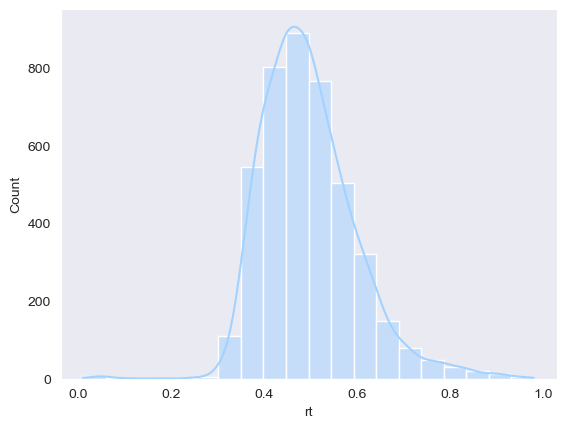

In [33]:
# TARGET DISTRIBUTION

sns.set_style("dark")
sns.set_palette("dark")

# Plot histogram using histplot
sns.histplot(y_m, kde=True, edgecolor='white', linewidth=1, color='#a2d2ff', bins=20)


#skewness and kurtosis
print("Skewness: %f" % y_m.skew())
print("Kurtosis: %f" % y_m.kurt())

1. The 'rt' distribution is positively skewed (skewness = 0.791), indicating more data on the left side (lower response times) and few outliers on the right (higher response times).
2. The distribution has lighter tails (kurtosis = 2.106) compared to a normal distribution, suggesting fewer extreme values or outliers.

In [56]:
# MISSING VALUES
print('Missing Values:',df.isna().sum().max())






Missing Values: 0


# PREPROCESSING

DEALING WITH OUTLIERS

In [41]:
# EXTRACT OUTLIERS
extract_outliers(df)

,Column,Total Outliers
0,block,0
1,trial,0
2,rt,120


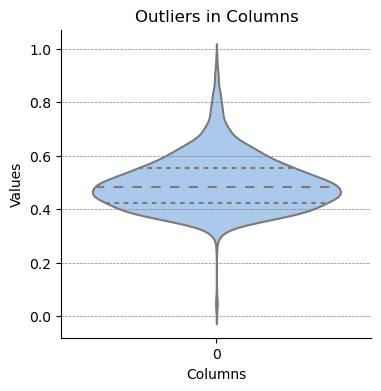

In [33]:

plot_outliers(df.rt, 'violin', (4, 4))






In [69]:
# REMOVE OUTLIERS
df_encoded = remove_outliers_IQR(df.copy(deep=True), column=None, k=1.5) 


print("DataFrame Original:")
print(df.shape)
print()
print("DataFrame without Outliers:")
print(df_encoded.shape)


DataFrame Original:
(4289, 5)

DataFrame without Outliers:
(4169, 5)


In [70]:
# OUTLIERS AFTER IQR
extract_outliers(df_encoded)

,Column,Total Outliers
0,block,0
1,trial,0
2,rt,15


# STATS (T-TEST )

A t test is used to compare the means of two sets of data. We compare the mean RTs for the congruent and incongruent conditions.
The t-test results show a significant difference (p < 0.05) between the mean response times (RTs) of the 'congruent' and 'incongruent' conditions. 
Participants responded significantly faster in the 'congruent' condition compared to the 'incongruent' condition (t = -10.21).

In [72]:

congr = df_avg[df_avg['flankers'] == 'congruent']['rt']
incongr = df_avg[df_avg['flankers'] == 'incongruent']['rt']

t, p = stats.ttest_rel(congr, incongr)

print(f'Congruent vs. Incongruent t = {t:.2f} p = {p:.4f}')

Congruent vs. Incongruent t = -10.21 p = 0.0000


In [81]:

# Create a box plot to compare the distribution of 'congruent' and 'incongruent' conditions
fig = go.Figure()

fig.add_trace(go.Box(y=congr, name='Congruent'))
fig.add_trace(go.Box(y=incongr, name='Incongruent'))

fig.update_layout(
    title='Reaction Time Distribution for Congruent and Incongruent Conditions',
    xaxis_title='Condition',
    yaxis_title='Reaction Time (RT)',
)

fig.show()


# CONCLUSION

In this flanker experiment, participants responded to center arrows while facing distractions from flanking arrows, either congruent or incongruent with the center arrow. The study aimed to explore if incongruent flanking results in slower reaction times due to visual confusion and cognitive interference. The data collected from 27 participants, with 160 trials each, supported the hypothesis. The t-test revealed a significant difference (t = -10.21, p < 0.05) between the mean response times of the 'congruent' and 'incongruent' conditions. **Participants responded significantly faster in the 'congruent' condition, suggesting that incongruent flanking leads to slower reaction times.**